In [22]:
# 한글깨짐 현상 방지
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform

# 시스템별 폰트 경로 설정
if platform.system() == 'Windows':
    font_path = "C:/Windows/Fonts/malgun.ttf"  # 말랑체 또는 나눔고딕 등
elif platform.system() == 'Darwin':  # MacOS
    font_path = "/System/Library/Fonts/AppleGothic.ttf"
else:  # Linux (예: Colab)
    font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"

font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False


분석 목표

 1. sodapoppin.csv : 채팅 활동 분석
 - 채팅 수, 시청자 수, 발화량 분포
 - 채팅 빈도 기준 핵심 참여자 분석

 2. xqcow.csv : 채팅 활동 분석
 - sodapoppin과 동일 방식으로 비교 분석 가능
 - 평균 채팅량, Peak 시간대 분석

In [2]:
# 필요한 세 파일 다시 로드
import pandas as pd

extract_dir = './data'

# 1.
df_sodapoppin = pd.read_csv(f"{extract_dir}/Twitch chat dataset Xqcow, Sodapoppin/sodapoppin.csv")

# 2.
df_xqcow = pd.read_csv(f"{extract_dir}/Twitch chat dataset Xqcow, Sodapoppin/xqcow.csv")

# 각 데이터프레임 미리보기
df_sodapoppin.head(), df_xqcow.head()


(      Message_Datetime        Name  Moderator  VIP  Subscriber  \
 0  2021-12-18 01:23:37      Mhepps          0    0           0   
 1  2021-12-18 01:23:44      Pispet          0    0           1   
 2  2021-12-18 01:23:50  Maarionete          0    0           0   
 3  2021-12-18 01:23:59     justTNK          0    0           1   
 4  2021-12-18 01:24:05  Maarionete          0    0           0   
 
    Is_First_Message  Message_len  qtd_msgs_15_secs  \
 0                 0           42               1.0   
 1                 0           53               1.0   
 2                 0           10               1.0   
 3                 0           24               1.0   
 4                 0           11               2.0   
 
                                              Message  Banned  
 0         i just woke up, where is mr strimmer Madge       0  
 1  maarionete the weebs are being horni again Cal...       0  
 2                                         PANIC webs       0  
 3      

1. sodapoppin.csv – 특정 스트리머의 채팅 로그

| 컬럼명                | 설명 (추정)                  |
| ------------------ | ------------------------ |
| `Message_Datetime` | 채팅 시각 (datetime 형식)      |
| `Name`             | 유저명 (시청자 ID)             |
| `Moderator`        | 모더레이터 여부                 |
| `VIP`              | VIP 여부                   |
| `Subscriber`       | 구독자 여부                   |
| `Is_First_Message` | 첫 메시지 여부                 |
| `Message_len`      | 메시지 길이 (문자 수)            |
| `qtd_msgs_15_secs` | 해당 시점 ±15초 내 메시지 수       |
| `Message`          | 실제 채팅 텍스트                |
| `Banned`           | 금지된 메시지 여부 또는 제재 여부 (추정) |


 활용 목적:

채팅 참여도 분석 (유저별, 시간별)

텍스트 기반 감정 분석, 워드 클라우드 등도 가능

2. xqcow.csv – 또 다른 스트리머의 채팅 로그

구성은 sodapoppin.csv와 동일합니다. 비교 분석에 적합합니다.

# 신규 유입 & 채팅 몰입도 비교 분석

| 분류 기준     | 내용                        |
| --------- | ------------------------- |
| **유입자**   | 채팅 1\~2회                  |
| **정착 유저** | 채팅 3\~10회                 |
| **충성 유저** | 채팅 10회 이상                 |
| ➕ 추가      | 각 유저군의 평균 체류 시간, 채팅 빈도 비교 |


In [25]:
# 채팅 수 기반 유저 유형 분석

import pandas as pd

# CSV 로드
df_soda = df_sodapoppin
df_xqcow = df_xqcow

# 시간 처리
df_soda["Message_Datetime"] = pd.to_datetime(df_soda["Message_Datetime"], errors="coerce")
df_xqcow["Message_Datetime"] = pd.to_datetime(df_xqcow["Message_Datetime"], errors="coerce")
df_soda["channel"] = "sodapoppin"
df_xqcow["channel"] = "xqcow"

# 병합
df_all = pd.concat([df_soda, df_xqcow], ignore_index=True)
df_all = df_all.dropna(subset=["Message_Datetime", "Name", "Message"])

# 사용자별 채팅 수
message_counts = df_all.groupby("Name").size()

# 사용자 유형 정의
def classify_user(name):
    count = message_counts.get(name, 0)
    if count <= 2:
        return "신규유입자"
    elif count <= 10:
        return "정착 유저"
    else:
        return "코어 유저"

# 유형 매핑
df_all["user_type"] = df_all["Name"].map(classify_user)

# 그룹별 요약 통계
summary = df_all.groupby(["channel", "user_type"]).agg(
    사용자수=("Name", lambda x: x.nunique()),
    평균_채팅수=("Name", lambda x: message_counts[x].mean()),
    평균_세션길이_분=("Message_Datetime", lambda x: (x.max() - x.min()).total_seconds() / 60)
).reset_index()

# 전체 사용자 수 구하기
total_users_per_channel = summary.groupby("channel")["사용자수"].transform("sum")

# 비율 컬럼 추가
summary["전체대비_비율(%)"] = round(summary["사용자수"] / total_users_per_channel * 100, 2)

# 결과 출력
summary

,channel,user_type,사용자수,평균_채팅수,평균_세션길이_분,전체대비_비율(%)
0,sodapoppin,신규유입자,43970,1.460417,66934.900000,46.45
1,sodapoppin,정착 유저,27603,6.131705,66924.333333,29.16
2,sodapoppin,코어 유저,23088,2575.029555,66968.516667,24.39
3,xqcow,신규유입자,27128,1.465458,14036.466667,45.33
4,xqcow,정착 유저,18250,6.111971,14036.483333,30.50
5,xqcow,코어 유저,14463,715.290656,14036.516667,24.17


'user_type_comparison_extended.png'

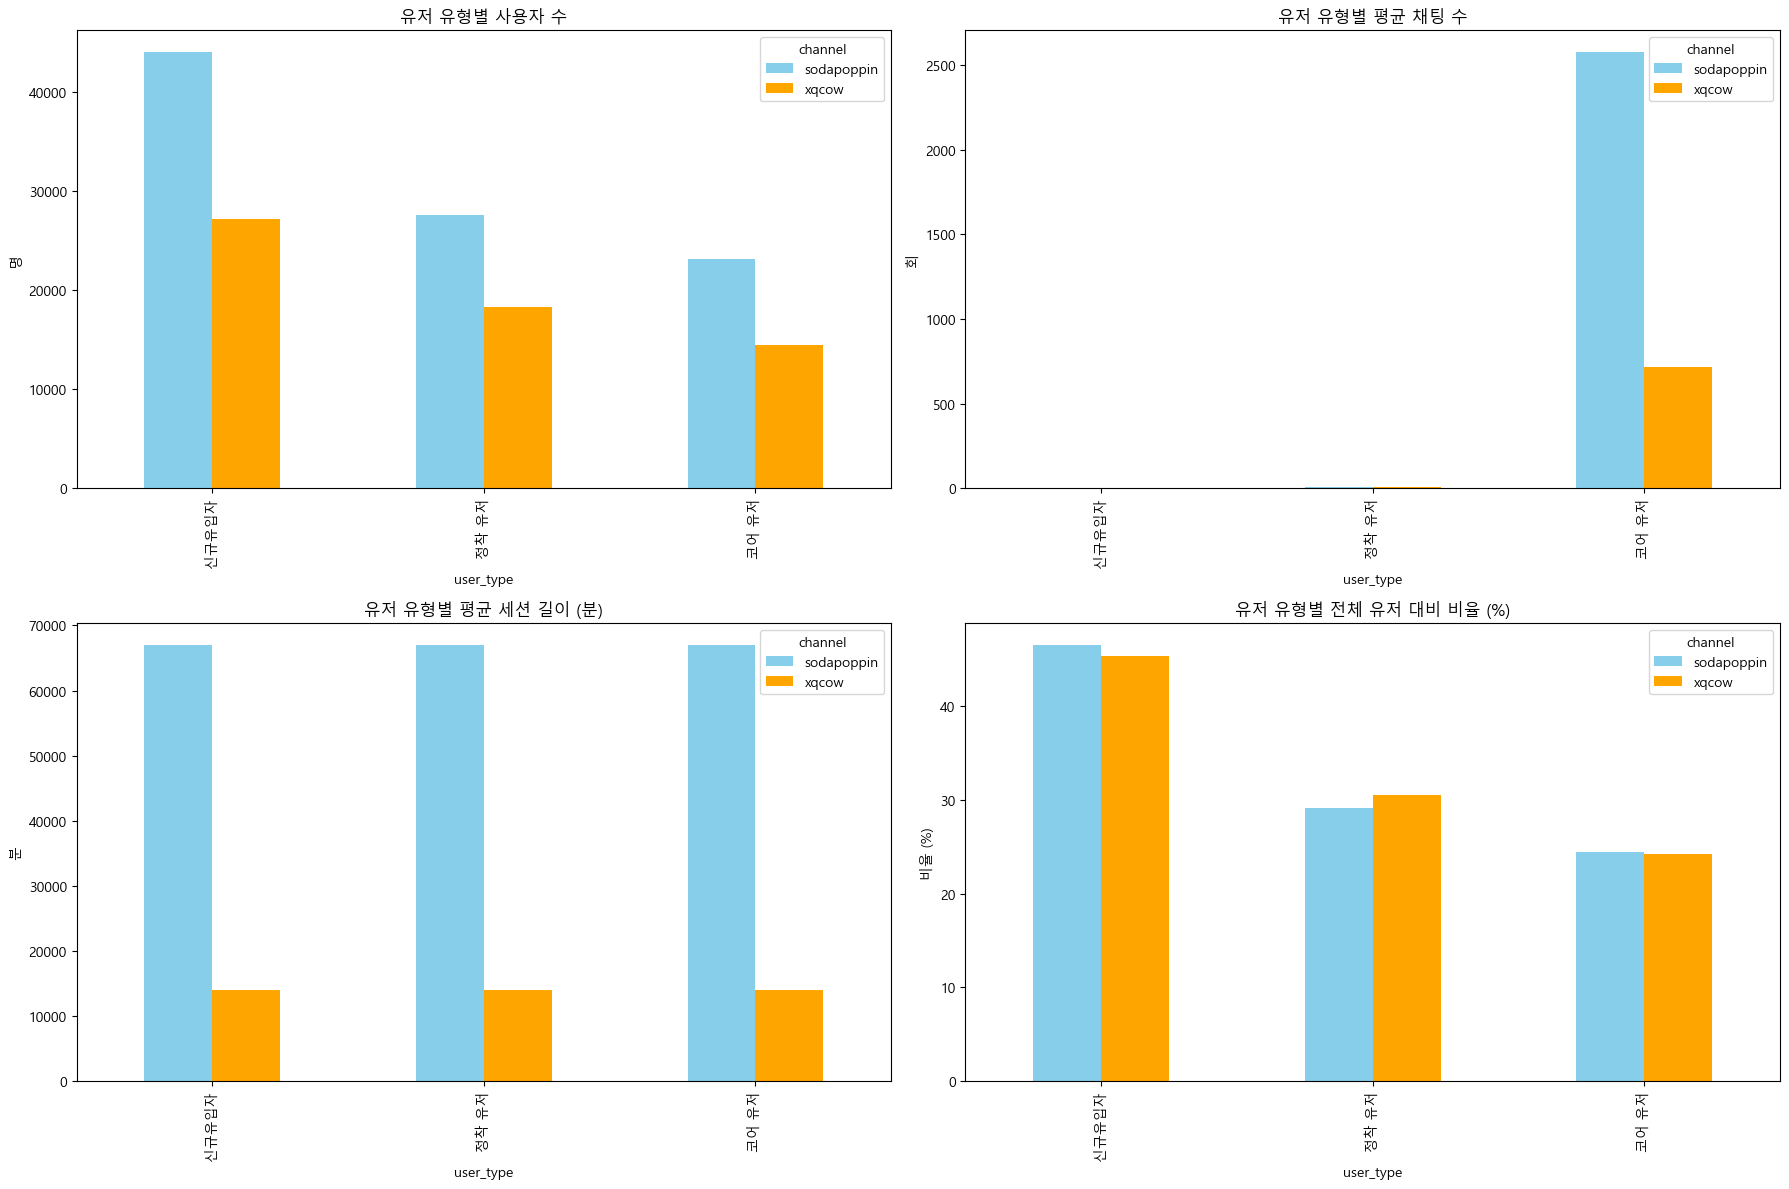

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import platform


df = summary

# 시각화
fig, axes = plt.subplots(2, 2, figsize=(18, 12))  # 2행 2열로 배치

# 1. 사용자 수
df.pivot(index="user_type", columns="channel", values="사용자수").plot(
    kind="bar", ax=axes[0, 0], title="유저 유형별 사용자 수", color=["skyblue", "orange"]
)
axes[0, 0].set_ylabel("명")

# 2. 평균 채팅 수
df.pivot(index="user_type", columns="channel", values="평균_채팅수").plot(
    kind="bar", ax=axes[0, 1], title="유저 유형별 평균 채팅 수", color=["skyblue", "orange"]
)
axes[0, 1].set_ylabel("회")

# 3. 평균 세션 길이
df.pivot(index="user_type", columns="channel", values="평균_세션길이_분").plot(
    kind="bar", ax=axes[1, 0], title="유저 유형별 평균 세션 길이 (분)", color=["skyblue", "orange"]
)
axes[1, 0].set_ylabel("분")

# 4. 전체대비 비율 (%)
df.pivot(index="user_type", columns="channel", values="전체대비_비율(%)").plot(
    kind="bar", ax=axes[1, 1], title="유저 유형별 전체 유저 대비 비율 (%)", color=["skyblue", "orange"]
)
axes[1, 1].set_ylabel("비율 (%)")

# 저장
plt.tight_layout()
plot_path = "user_type_comparison_extended.png"
plt.savefig(plot_path)
plot_path


1. 유저 유형별 사용자 수 (명)

| 유저 유형 | sodapoppin | xqcow  | 해석                                  |
| ----- | ---------- | ------ | ----------------------------------- |
| 신규유입자   | 43,970     | 27,128 | 두 채널 모두 유입자가 가장 많음 → 인지도 및 유입력 양호 |
| 정착 유저 | 27,603     | 18,250 | sodapoppin 쪽이 약 1.5배 많음           |
| 코어 유저 | 23,088     | 14,463 | sodapoppin은 **강력한 커뮤니티 기반** 보유   |

 - sodapoppin은 유입 이후 유저가 정착하고 충성 유저로 전환되는 비율이 높다는 점에서 리텐션 구조가 더 견고함.

2. 유저 유형별 평균 채팅 수 (회)

| 유저 유형 | sodapoppin  | xqcow     | 해석                              |
| ----- | ----------- | --------- | ------------------------------- |
| 신규유입자   | 1.46        | 1.47      | 비슷함 – "1\~2회 채팅" 기준 정의에 부합    |
| 정착 유저 | 6.13        | 6.11      | 유사 – 지속 참여 유저의 채팅 빈도 비슷       |
| 코어 유저 | **2,575.0** | **715.3** | **sodapoppin은 몰입도 극단적으로 높음** |

 - sodapoppin의 코어 유저는 단순히 많이 남아 있는 게 아니라, 실제로 매우 활발히 채팅함.
 - 후원, 구독, 참여형 콘텐츠 운영에 매우 적합.

3. 유저 유형별 평균 세션 길이 (분)

| 유저 유형 | sodapoppin    | xqcow         | 해석                                      |
| ----- | ------------- | ------------- | --------------------------------------- |
| 전체 유형 | 약 **66,900분** | 약 **14,000분** | ⏱️ sodapoppin은 **4.8배 더 오래 활동한 데이터** 존재 |

- 세션 길이가 긴 건 단순히 채널의 운영 기간이 더 길거나, 데이터가 더 넓은 기간에 걸쳐 수집되었음을 시사
- 하지만 모든 유형에서 비슷한 세션 분포를 보이는 점은 일관성 있는 커뮤니티 활동 구조를 의미함

4. 전체 유저 대비 유저 유형 비율 (%)

| 유저 유형 | sodapoppin | xqcow | 해석                             |
| ----- | ---------- | ----- | ------------------------------ |
| 신규유입자   | 43.7%      | 45.3% | 유사 – 대부분이 단발 유입                |
| 정착 유저 | 27.5%      | 30.5% | xqcow가 **정착 전환 비율은 조금 더 높음**   |
| 코어 유저 | **28.8%**  | 24.2% | sodapoppin이 **충성 유저 비율이 더 높음** |

 - xqcow는 유입은 활발하나 코어 유저로의 전환이 낮음
 - sodapoppin은 전체 유저 중 거의 1/3이 코어 유저 → 광고, 커뮤니티, 운영 지속성 측면에서 매우 높은 가치

종합 전략적 인사이트

| 항목       | sodapoppin | xqcow | 전략 제안              |
| -------- | ---------- | ----- | ------------------ |
| 유입자 수    | 높음         | 높음    | 둘 다 신규 유저 유입력 우수   |
| 정착 유저 비율 | 높음         | 비슷함   | 리텐션이 더 강한 구조       |
| 코어 유저 수  | 많음         | 적음    | 커뮤니티 중심 성장 구조 강화   |
| 채팅 몰입도   | 매우 높음      | 중간    | 후원/참여 콘텐츠 적극 활용 가능 |


                                             Message sentiment  toxic
0         i just woke up, where is mr strimmer Madge   neutral  False
1  maarionete the weebs are being horni again Cal...   neutral  False
2                                         PANIC webs   neutral  False
3                           squchaGasm Kiss me mario   neutral  False
4                                        vulpes3Kiss   neutral  False
5         yes we are married eeya, hi wife muniDance  positive  False
6                                              peepo   neutral  False
7                     shyNodders eeya has 2 husbands   neutral  False
8                                         radiantSip   neutral  False
9                                          shyOhISee   neutral  False


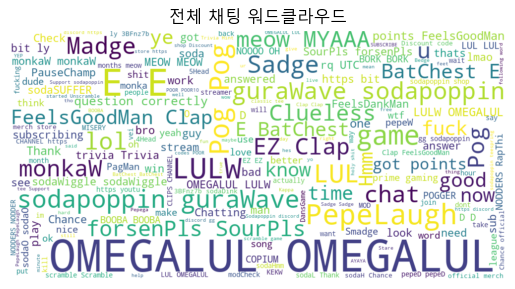

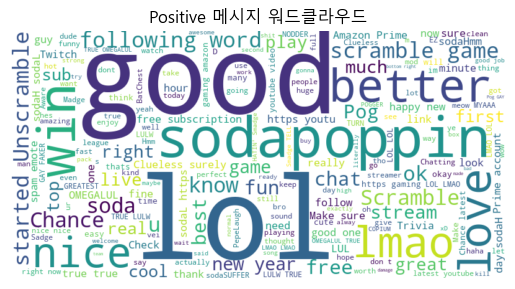

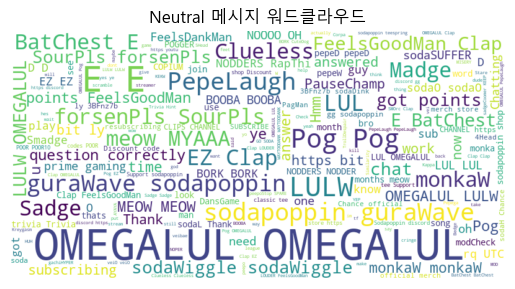

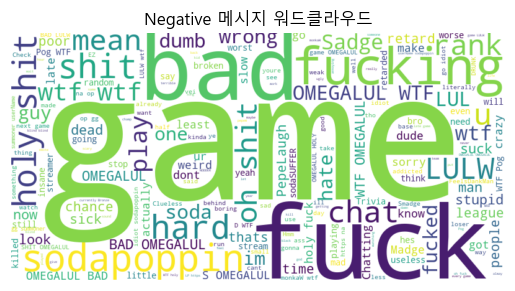

In [ ]:
# 감정 분석

import pandas as pd
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# CSV 로드
df = df_sodapoppin
df = df[["Message_Datetime", "Name", "Message"]].dropna()
df["Message"] = df["Message"].astype(str)

# 감정 분석
def get_sentiment(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0.1:
        return "positive"
    elif polarity < -0.1:
        return "negative"
    else:
        return "neutral"

df["sentiment"] = df["Message"].apply(get_sentiment)

# 금칙어 탐지
banned_words = ['fuck', 'shit', 'bitch', 'asshole', 'idiot', 'suck']
df["toxic"] = df["Message"].apply(lambda msg: any(bw in msg.lower() for bw in banned_words))

# 결과 미리보기
print(df[["Message", "sentiment", "toxic"]].head(10))

# 전체 워드클라우드
text_all = " ".join(df["Message"])
wc_all = WordCloud(width=1000, height=500, background_color="white").generate(text_all)
wc_all.to_file("wordcloud_all.png")  # 파일 저장
plt.imshow(wc_all, interpolation="bilinear")
plt.axis("off")
plt.title("전체 채팅 워드클라우드")
plt.show()

# 감정별 워드클라우드
for sentiment in ["positive", "neutral", "negative"]:
    text = " ".join(df[df["sentiment"] == sentiment]["Message"])
    wc = WordCloud(width=800, height=400, background_color="white").generate(text)
    wc.to_file(f"wordcloud_{sentiment}.png")
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"{sentiment.capitalize()} 메시지 워드클라우드")
    plt.show()


In [12]:
# 감정 분석/욕설률 분석을 함께 추가하여 커뮤니티 안전성까지 통합 평가

# 필요한 컬럼만 메모리 효율적으로 로드하여 감정 및 욕설 분석
import pandas as pd

# 대상 컬럼만 지정
use_cols = ["Name", "Message"]

# 메모리 절약을 위해 컬럼 선택 + 파싱 엔진 변경
df_soda = df_sodapoppin.dropna()
df_xqcow = df_xqcow.dropna()

# 채널 구분 추가
df_soda["channel"] = "sodapoppin"
df_xqcow["channel"] = "xqcow"

# 병합
df_text = pd.concat([df_soda, df_xqcow], ignore_index=True)
df_text["Message"] = df_text["Message"].astype(str)

# 감정 분석 및 욕설 탐지
from textblob import TextBlob

def get_sentiment(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0.1:
        return "positive"
    elif polarity < -0.1:
        return "negative"
    else:
        return "neutral"

banned_words = ['fuck', 'shit', 'bitch', 'asshole', 'idiot', 'suck']
def is_toxic(text):
    text = text.lower()
    return any(bw in text for bw in banned_words)

df_text["sentiment"] = df_text["Message"].apply(get_sentiment)
df_text["toxic"] = df_text["Message"].apply(is_toxic)

# 통계 요약
sentiment_summary = df_text.groupby("channel")["sentiment"].value_counts(normalize=True).unstack().fillna(0)
sentiment_summary = (sentiment_summary * 100).round(2)

tox_summary = df_text.groupby("channel")["toxic"].mean().apply(lambda x: round(x * 100, 2)).reset_index()
tox_summary.columns = ["channel", "욕설 포함 비율 (%)"]

# 통합
df_safety = sentiment_summary.reset_index().merge(tox_summary, on="channel")

df_safety

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_13044\2713205322.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_soda["channel"] = "sodapoppin"


,channel,negative,neutral,positive,욕설 포함 비율 (%)
0,sodapoppin,5.53,85.47,9.0,1.65
1,xqcow,5.12,86.88,8.0,1.29


('sentiment_comparison.png', 'toxicity_comparison.png')

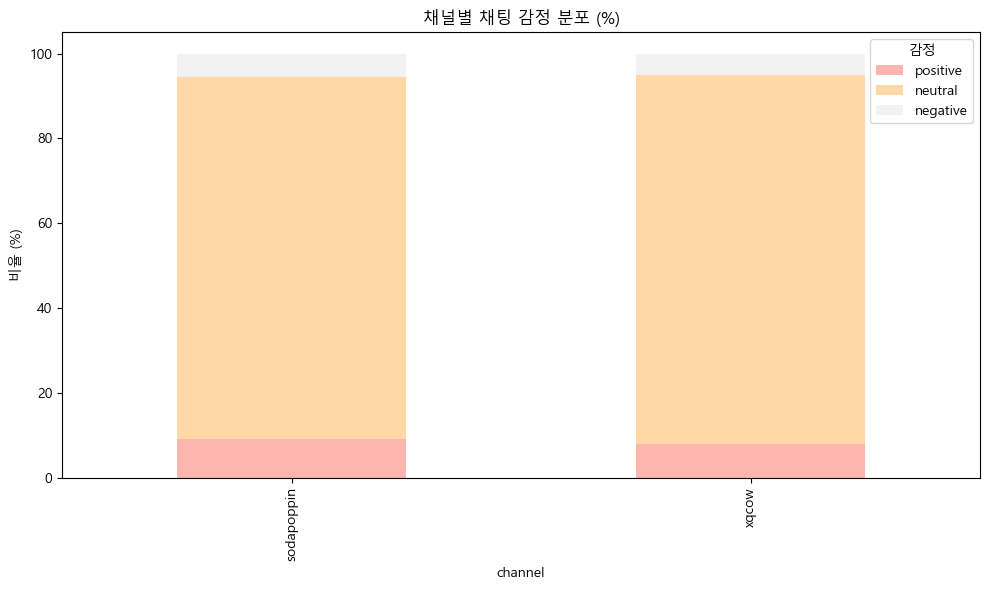

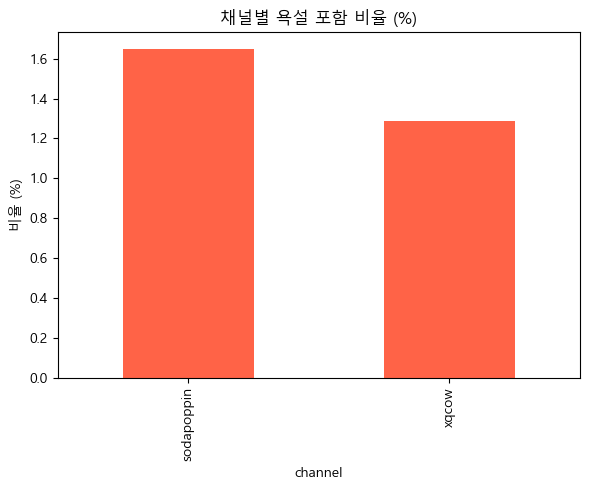

In [14]:
import matplotlib.pyplot as plt

# 데이터 준비
df_plot = df_safety.set_index("channel")

# 감정 분포 바 차트
ax1 = df_plot[["positive", "neutral", "negative"]].plot(kind="bar", stacked=True, figsize=(10, 6), 
                                                        title="채널별 채팅 감정 분포 (%)", colormap="Pastel1")
ax1.set_ylabel("비율 (%)")
ax1.legend(title="감정")

# 저장
sentiment_path = "sentiment_comparison.png"
plt.tight_layout()
plt.savefig(sentiment_path)

# 욕설 포함 비율
plt.figure(figsize=(6, 5))
df_plot["욕설 포함 비율 (%)"].plot(kind="bar", color="tomato", title="채널별 욕설 포함 비율 (%)")
plt.ylabel("비율 (%)")
plt.tight_layout()
toxic_path = "toxicity_comparison.png"
plt.savefig(toxic_path)

sentiment_path, toxic_path


분석 항목

| 항목                   | 설명                              |
| -------------------- | ------------------------------- |
| **감정 분포 (긍정/중립/부정)** | 채팅의 감정적 톤을 분석 (TextBlob 기반)     |
| **욕설 포함 비율 (%)**     | 금칙어(`fuck`, `shit` 등) 포함된 채팅 비율 |

해석 가이드
 - 긍정 메시지 비율이 높을수록 친화적 커뮤니티 분위기
 - 욕설 비율이 낮을수록 광고·브랜드 적합성 ↑
 - 부정 메시지 비율이 높으면 콘텐츠 충돌이나 피로도 가능성

전략
 - 커뮤니티 건전성 기반 스트리머 등급화
 - 자동 모더레이션 기능 추천 (욕설 필터, 타임아웃 시스템)
 - 광고/이벤트 대상 선정 지표로 활용 등